<a href="https://colab.research.google.com/github/ValeraKayumov/music_project/blob/main/Valera_Kayumov_project_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Subject: Analysis of Monthly Subscription Renewal on a Music Platform**

Hello everyone! My name is Valery Kayumov, and I am a graduate of the Institute of Management, Economics, and Finance at Kazan Federal University (KFU). I work as a product analyst. My work tasks inspired me to develop this project idea. However, this project is not related to the educational sector.

For contact:
KayumovValera@gmail.com
https://t.me/Valera_Kayumov

Scenario:
There is a music streaming platform called "Zvuk," where customers renew their subscriptions on a monthly basis. It is widely known within the company that, on average, 85-95% of subscriptions are renewed from month to month. In this project, we will focus on September and October. Last year, 90% of September's customers renewed their subscription for October. We will use last year's data for comparison with this year and refer to it occasionally. This year, only 70% of customers renewed their subscription from September to October.

Objective:
Why was the renewal rate from September to October in 2022 20% lower than the company's standard average renewal rate (90%)?

P.S. Some data may seem inconsistent with real life, and that is indeed the case. All values are completely random. The goal is not to draw real-life conclusions. The task is purely based on fictional data from a parallel world to demonstrate the thought process of an analyst. :)

In [ ]:
'''
In this task, Google Sheets are used as a database. We will connect to them and use the Sheets API.
Each separate sheet in the spreadsheet represents a table in our imaginary database.

In this project, we have a total of 6 tables:

Clients of September 2021
Clients of October 2021
Clients of September 2022
Clients of October 2022
The data export contains:

Unique Client ID
Name, Age, City of Residence
Subscription Month (e.g., a subscription paid for September is indicated as 9)
Interests (favorite genre, selected by the user during registration)
Listening Time per Month (number of minutes of music listened to)
Favorite Artist (also selected by the user during registration)
'''

from google.oauth2 import service_account
from oauth2client.client import Credentials
import gspread as gs
import pandas as pd
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Main Links Used in the Project:
service_account_path = '/content/drive/MyDrive/KayumovProject/secret.json'
database = 'https://docs.google.com/spreadsheets/d/19yNqgCijktMA1_5lZ6Ai91r1457CsYFV88jqoc1nwJM/edit#gid=0'

# We create a client to easily interact with the Google Sheets API through it.
scope = ['https://www.googleapis.com/auth/spreadsheets',
         "https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name(service_account_path, scope)
client = gs.authorize(credentials)

In [ ]:
def get_gatabase_records(sheet_name):
  '''A function to retrieve data from Google Sheets.
  Just pass the sheet name, and it returns the data as a DataFrame.'''
  sh = client.open_by_url(database)
  ws = sh.worksheet(sheet_name)
  df = pd.DataFrame(ws.get_all_records())
  return df

'''
A subscription renewal is considered any purchase by a client for the next month.
Therefore, we will clean the data and keep only unique users, removing any duplicates found in the database.
We will store the tables in 4 variables for further processing.
'''
september_21 = get_gatabase_records(sheet_name = 'Consumer_sep_21').drop_duplicates(subset=['id'])
october_21 = get_gatabase_records(sheet_name = 'Consumer_oct_21').drop_duplicates(subset=['id'])
september_22 = get_gatabase_records(sheet_name = 'Consumer_sep_22').drop_duplicates(subset=['id'])
october_22 = get_gatabase_records(sheet_name = 'Consumer_oct_22').drop_duplicates(subset=['id'])

# Выведем одну из таблиц, чтобы держать ее перед глазами для удобства
september_21.head()

,id,Name,Age,City,Month,interests,Listening_time_min,favorite_singer
0,100,Valera,23,Moscow,9,Rock,9800,Eminem
1,101,Nuriya,20,Ufa,9,Rap,7838,Kid Cudi
2,102,Egor,17,Kazan,9,Ode,1707,Arash
3,103,Artur,35,Saint-petersburg,9,Opera,1752,Rihanna
4,104,Ilьvir,17,Nizhny Novgorod,9,Rap,3725,Bruce Springsteen


In [ ]:
'''
First, let's verify whether the renewal rate from September to October this year has indeed dropped
and if the initial data is correct.
We will create a function that allows us to plug in the months and calculate the renewal rates.
'''

def count_prolongation(first_month, second_month):
  second_month['boolean_prolongation'] = 1
  prolongation = first_month[['id','Name','Month']] \
                  .merge(second_month[['id', 'boolean_prolongation']], \
                    on = 'id', how = 'left').fillna(0) \
                  .groupby(['Month'])['boolean_prolongation'] \
                  .agg(['mean', 'count', 'sum'])\
                  .reset_index().round(4)
  prolongation['mean'] = prolongation['mean'] * 100
  prolongation = prolongation\
                  .rename(columns = {'mean': 'The renewal rate for October',
                                    'count': 'The number of payments in September',
                                    'sum': 'The number of customers who renewed for October'})
  return prolongation

display(count_prolongation(september_21, october_21))
display(count_prolongation(september_22, october_22))

# Output: The conditions of the task are correct. The renewal rates are indeed around 90% and 70%. There is a 20% drop observed

,Month,The renewal rate for October,The number of payments in September,The number of customers who renewed for October
0,9,89.37,301,269.0


,Month,The renewal rate for October,The number of payments in September,The number of customers who renewed for October
0,9,70.7,372,263.0


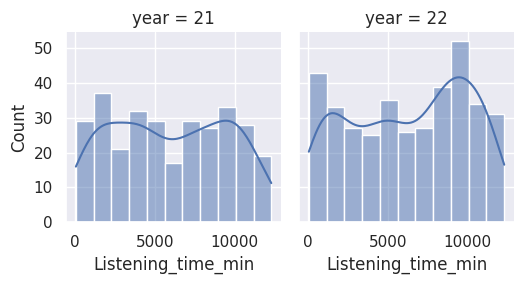

In [ ]:
'''
The first thing to check is user activity, expressed in minutes of music listened to.
This will give us an overall view of the situation.
If people are listening less, we will need to investigate why.
This will be a more specific issue than the general question of "why are our renewals low?"
'''

# Let's generate charts showing the number of minutes listened to and the number of people.

september_21['year'] = 21
september_22['year'] = 22
sep_two_year = pd.concat([september_21, september_22])

Listening_time_sep = sns.displot(data=sep_two_year, x="Listening_time_min",
                                 col="year", height=3, aspect=0.9, kde=True)

# Output: The charts do not indicate any significant deviations this year compared to the previous year.
# The distribution of listening minutes is similar in both years.
# The graphs only show that the total number of people was lower in 2021.
# Additionally, this year there is a slight increase in the number of people listening to around 10,000 minutes of music per month.

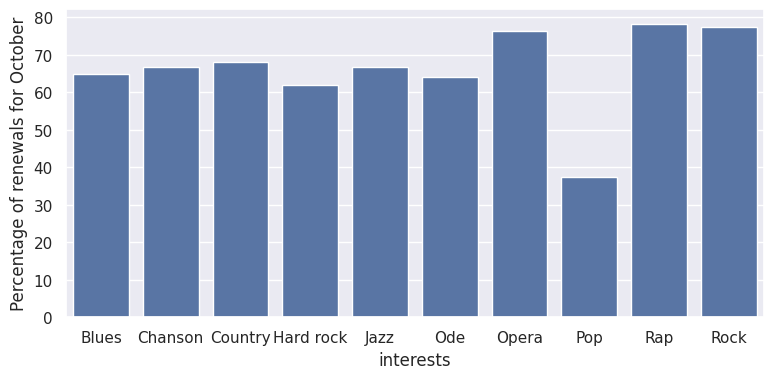

In [ ]:
'''
Next, we will decompose the September 2022 data into renewals based on user interests and favorite artists.
Hypothesis: We may be losing clients with certain interests or favorite artists.
We will identify any differing categories.
'''

def prolong_interest(first_month, second_month):
  second_month['boolean_prolongation'] = 1
  prolong_interest = first_month[['id','Name','Month', 'interests']] \
                  .merge(second_month[['id','interests', 'boolean_prolongation']], \
                    on = ['id', 'interests'], how = 'left').fillna(0) \
                  .groupby(['interests'])['boolean_prolongation'] \
                  .agg(['mean', 'count', 'sum'])\
                  .reset_index().round(4)
  prolong_interest['mean'] = prolong_interest['mean'] * 100
  prolong_interest = prolong_interest\
                  .rename(columns = {'mean': 'Percentage of renewals for October',
                                    'count': 'Number of payments in September',
                                    'sum': 'Number of customers who renewed for October'})
  return prolong_interest

prolong_interest = prolong_interest(september_22, october_22)
sns.set(rc={'figure.figsize':(9, 4)})
interests_bar = sns.barplot(data=prolong_interest,
                            x="interests", y="Percentage of renewals for October",
                            capsize = 0.5)

# Output: The category of pop music enthusiasts stands out.
# Their renewal rates are significantly lower compared to other genres.

In [ ]:
prolong_interest['Weight of the number of clients'] = \
  (prolong_interest['Number of payments in September'] /
   prolong_interest['Number of payments in September'].sum()) * 100

prolong_interest.sort_values(by = 'Percentage of renewals for October').head()


# As we can see, the total number of pop music enthusiasts is 6.45%.
# Even if we had lost all pop music enthusiasts in October,
# the renewal rate would not have dropped by 20% compared to last year.
# It is unlikely that user interests would account for the low renewal percentage.
# No outliers were found except for pop music.
# Unless the percentage drop is uniform across each interest category,
# if we do not find any issues with favorite artists, we will revisit this hypothesis.

,interests,Percentage of renewals for October,Number of payments in September,Number of customers who renewed for October,Weight of the number of clients
7,Pop,37.50,24,9.0,6.451613
3,Hard rock,62.07,29,18.0,7.795699
5,Ode,64.00,25,16.0,6.720430
0,Blues,64.86,37,24.0,9.946237
1,Chanson,66.67,12,8.0,3.225806


In [ ]:
# Now let's examine the users' favorite artists.

def prolong_singer(first_month, second_month):
  second_month['boolean_prolongation'] = 1
  prolong_singer = first_month[['id','Name','Month', 'favorite_singer']] \
                  .merge(second_month[['id','favorite_singer', 'boolean_prolongation']], \
                    on = ['id', 'favorite_singer'], how = 'left').fillna(0) \
                  .groupby(['favorite_singer'])['boolean_prolongation'] \
                  .agg(['mean', 'count', 'sum'])\
                  .reset_index().round(4)
  prolong_singer['mean'] = prolong_singer['mean'] * 100
  prolong_singer = prolong_singer\
                  .rename(columns = {'mean': 'Percentage of renewals for October',
                                    'count': 'Number of payments in September',
                                    'sum': 'Number of customers who renewed for October'})
  return prolong_singer

prolong_singer = prolong_singer(september_22, october_22)

prolong_singer['Weight of the number of clients'] = \
  (prolong_singer['Number of payments in September'] /
   prolong_singer['Number of payments in September'].sum()) * 100

prolong_singer.sort_values(by = 'Percentage of renewals for October').head()

# We immediately notice that there are no renewals for Bob Dylan.
# Recently, due to intellectual property rights, his songs were removed from the "Zvuk" service.
# Bob Dylan enthusiasts made up almost 20% of the total.
# Therefore, their loss has reduced the overall renewal rate by the same percentage.

,favorite_singer,Percentage of renewals for October,Number of payments in September,Number of customers who renewed for October,Weight of the number of clients
0,Bob Dylan,0.00,72,0.0,19.354839
3,Elton John,28.09,89,25.0,23.924731
5,Rihanna,70.73,41,29.0,11.021505
1,Bryan Adams,82.50,40,33.0,10.752688
4,Eminem,95.12,41,39.0,11.021505


#### Conclusion: The "Zvuk" service lost clients who were fans of Bob Dylan. His fans made up 20% of the audience. They did not renew their subscriptions, resulting in a 20% drop in the overall renewal rate.

<!-- впрар -->